In [ ]:


from google.colab import drive
drive.mount('/content/drive')


!pip install -q roboflow


import tensorflow as tf
import numpy as np
import os
from pathlib import Path

from google.colab import userdata
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")


from roboflow import Roboflow

rf = Roboflow(api_key=os.environ["ROBOFLOW_API_KEY"])
project = rf.workspace("aria-4ivto").project("realwaste-efficient-b3")
dataset = project.version(1).download("folder")

DATA_DIR = dataset.location
print("Dataset path:", DATA_DIR)
print("Folders:", os.listdir(DATA_DIR))


IMG_SIZE = (300, 300)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading Roboflow workspace...
loading Roboflow project...
Dataset path: /content/realwaste-EFFICIENT-B3-1
Folders: ['README.dataset.txt', 'test', 'valid', 'README.roboflow.txt', 'train']


In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

NUM_CLASSES = len(train_ds.class_names)
print("Classes:", train_ds.class_names)

augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (augment(x), y),
    num_parallel_calls=AUTOTUNE
)


train_ds = train_ds.map(
    lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)),
    num_parallel_calls=AUTOTUNE
)

val_ds = val_ds.map(
    lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)),
    num_parallel_calls=AUTOTUNE
)


def mixup(x, y, alpha=0.2):
    batch_size = tf.shape(x)[0]
    lam = tf.random.uniform([], 0, 1)
    index = tf.random.shuffle(tf.range(batch_size))
    x = lam * x + (1 - lam) * tf.gather(x, index)
    y = lam * y + (1 - lam) * tf.gather(y, index)
    return x, y

train_ds = train_ds.map(mixup, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)


def se_block(x, ratio=16):
    filters = x.shape[-1]
    se = tf.keras.layers.GlobalAveragePooling2D()(x)
    se = tf.keras.layers.Dense(filters // ratio, activation="relu")(se)
    se = tf.keras.layers.Dense(filters, activation="sigmoid")(se)
    se = tf.keras.layers.Reshape((1, 1, filters))(se)
    return tf.keras.layers.Multiply()([x, se])

Found 7604 files belonging to 9 classes.
Found 475 files belonging to 9 classes.
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [ ]:

base = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3)
)

base.trainable = True

inputs = tf.keras.Input(shape=(300, 300, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base(x, training=True)
x = se_block(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb3      │ (None, 10, 10,    │ 10,783,535 │ input_layer_2[0]… │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ efficientnetb3[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 96)        │    147,552 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1536)      │    148,992 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ dense_1[0][0]     │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 10, 10,    │          0 │ efficientnetb3[0… │
│                     │ 1536)             │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │     49,184 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 9)         │        297 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,129,560 (42.46 MB)

 Trainable params: 11,042,257 (42.12 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [7]:
OUT = Path("/content/drive/MyDrive/checkpoints_effb3")
OUT.mkdir(parents=True, exist_ok=True)

ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(OUT / "epoch_{epoch:02d}.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)


In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[ckpt]
)


Epoch 1/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.3654 - loss: 1.8951
Epoch 1: val_accuracy improved from -inf to 0.77474, saving model to /content/drive/MyDrive/checkpoints_effb3/epoch_01.h5


476/476 ━━━━━━━━━━━━━━━━━━━━ 420s 565ms/step - accuracy: 0.3656 - loss: 1.8948 - val_accuracy: 0.7747 - val_loss: 0.8241
Epoch 2/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.6404 - loss: 1.4398
Epoch 2: val_accuracy improved from 0.77474 to 0.86105, saving model to /content/drive/MyDrive/checkpoints_effb3/epoch_02.h5


476/476 ━━━━━━━━━━━━━━━━━━━━ 174s 365ms/step - accuracy: 0.6405 - loss: 1.4397 - val_accuracy: 0.8611 - val_loss: 0.5797
Epoch 3/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7238 - loss: 1.2806
Epoch 3: val_accuracy improved from 0.86105 to 0.87789, saving model to /content/drive/MyDrive/checkpoints_effb3/epoch_03.h5


476/476 ━━━━━━━━━━━━━━━━━━━━ 196s 352ms/step - accuracy: 0.7238 - loss: 1.2805 - val_accuracy: 0.8779 - val_loss: 0.4960
Epoch 4/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7770 - loss: 1.2020
Epoch 4: val_accuracy improved from 0.87789 to 0.88632, saving model to /content/drive/MyDrive/checkpoints_effb3/epoch_04.h5


476/476 ━━━━━━━━━━━━━━━━━━━━ 169s 353ms/step - accuracy: 0.7769 - loss: 1.2021 - val_accuracy: 0.8863 - val_loss: 0.4724
Epoch 5/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7961 - loss: 1.1186
Epoch 5: val_accuracy improved from 0.88632 to 0.88842, saving model to /content/drive/MyDrive/checkpoints_effb3/epoch_05.h5


476/476 ━━━━━━━━━━━━━━━━━━━━ 168s 352ms/step - accuracy: 0.7961 - loss: 1.1186 - val_accuracy: 0.8884 - val_loss: 0.4232
Epoch 6/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8092 - loss: 1.1313
Epoch 6: val_accuracy improved from 0.88842 to 0.89684, saving model to /content/drive/MyDrive/checkpoints_effb3/epoch_06.h5


476/476 ━━━━━━━━━━━━━━━━━━━━ 166s 348ms/step - accuracy: 0.8091 - loss: 1.1313 - val_accuracy: 0.8968 - val_loss: 0.3673
Epoch 7/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8228 - loss: 1.0861
Epoch 7: val_accuracy improved from 0.89684 to 0.92000, saving model to /content/drive/MyDrive/checkpoints_effb3/epoch_07.h5


476/476 ━━━━━━━━━━━━━━━━━━━━ 205s 429ms/step - accuracy: 0.8228 - loss: 1.0861 - val_accuracy: 0.9200 - val_loss: 0.3328
Epoch 8/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.8289 - loss: 1.0815
Epoch 8: val_accuracy did not improve from 0.92000
476/476 ━━━━━━━━━━━━━━━━━━━━ 218s 337ms/step - accuracy: 0.8289 - loss: 1.0815 - val_accuracy: 0.9074 - val_loss: 0.3596
Epoch 9/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8291 - loss: 1.0815
Epoch 9: val_accuracy did not improve from 0.92000
476/476 ━━━━━━━━━━━━━━━━━━━━ 240s 417ms/step - accuracy: 0.8291 - loss: 1.0815 - val_accuracy: 0.9179 - val_loss: 0.3356
Epoch 10/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.8456 - loss: 1.0271
Epoch 10: val_accuracy improved from 0.92000 to 0.93053, saving model to /content/drive/MyDrive/checkpoints_effb3/epoch_10.h5


476/476 ━━━━━━━━━━━━━━━━━━━━ 163s 341ms/step - accuracy: 0.8456 - loss: 1.0271 - val_accuracy: 0.9305 - val_loss: 0.3189
Epoch 11/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8404 - loss: 1.0473
Epoch 11: val_accuracy did not improve from 0.93053
476/476 ━━━━━━━━━━━━━━━━━━━━ 164s 342ms/step - accuracy: 0.8404 - loss: 1.0472 - val_accuracy: 0.9242 - val_loss: 0.3181
Epoch 12/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8584 - loss: 0.9911
Epoch 12: val_accuracy did not improve from 0.93053
476/476 ━━━━━━━━━━━━━━━━━━━━ 164s 342ms/step - accuracy: 0.8584 - loss: 0.9911 - val_accuracy: 0.9242 - val_loss: 0.3036
Epoch 13/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8586 - loss: 0.9855
Epoch 13: val_accuracy did not improve from 0.93053
476/476 ━━━━━━━━━━━━━━━━━━━━ 164s 344ms/step - accuracy: 0.8586 - loss: 0.9855 - val_accuracy: 0.9263 - val_loss: 0.2868
Epoch 14/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8745 - loss: 0.9626
Epoc

476/476 ━━━━━━━━━━━━━━━━━━━━ 168s 351ms/step - accuracy: 0.8638 - loss: 0.9079 - val_accuracy: 0.9326 - val_loss: 0.2879
Epoch 20/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8914 - loss: 0.9135
Epoch 20: val_accuracy did not improve from 0.93263
476/476 ━━━━━━━━━━━━━━━━━━━━ 165s 344ms/step - accuracy: 0.8914 - loss: 0.9135 - val_accuracy: 0.9242 - val_loss: 0.2982


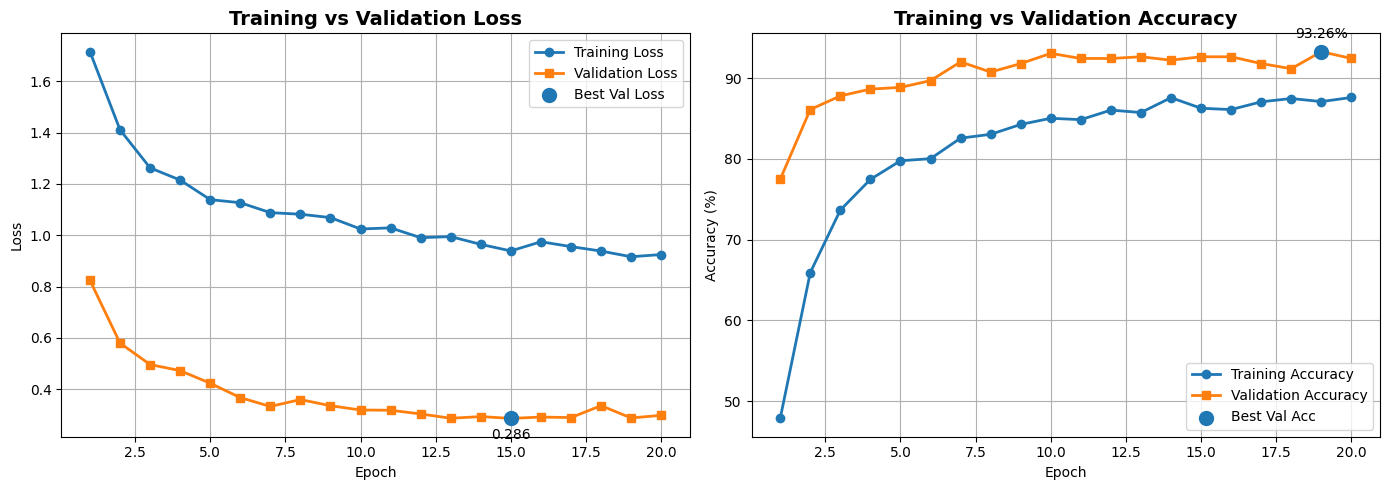

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


h = history.history

epochs = np.arange(1, len(h["loss"]) + 1)

train_loss = h.get("loss")
val_loss   = h.get("val_loss")

train_acc = h.get("accuracy") or h.get("acc")
val_acc   = h.get("val_accuracy") or h.get("val_acc")



fig, axs = plt.subplots(1, 2, figsize=(14, 5))


axs[0].plot(epochs, train_loss, marker="o", linewidth=2, label="Training Loss")
axs[0].plot(epochs, val_loss,   marker="s", linewidth=2, label="Validation Loss")

best_val_loss_idx = int(np.argmin(val_loss))
axs[0].scatter(epochs[best_val_loss_idx], val_loss[best_val_loss_idx], s=100, zorder=5, label="Best Val Loss")
axs[0].annotate(f"{val_loss[best_val_loss_idx]:.3f}",
                (epochs[best_val_loss_idx], val_loss[best_val_loss_idx]),
                textcoords="offset points", xytext=(0, -15), ha="center")

axs[0].set_title("Training vs Validation Loss", fontsize=14, fontweight="bold")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)


if train_acc is not None and val_acc is not None:
    train_acc_pct = np.array(train_acc) * 100
    val_acc_pct   = np.array(val_acc) * 100

    axs[1].plot(epochs, train_acc_pct, marker="o", linewidth=2, label="Training Accuracy")
    axs[1].plot(epochs, val_acc_pct,   marker="s", linewidth=2, label="Validation Accuracy")

    best_val_acc_idx = int(np.argmax(val_acc_pct))
    axs[1].scatter(epochs[best_val_acc_idx], val_acc_pct[best_val_acc_idx], s=100, zorder=5, label="Best Val Acc")
    axs[1].annotate(f"{val_acc_pct[best_val_acc_idx]:.2f}%",
                    (epochs[best_val_acc_idx], val_acc_pct[best_val_acc_idx]),
                    textcoords="offset points", xytext=(0, 10), ha="center")

    axs[1].set_ylabel("Accuracy (%)")
    axs[1].legend()
else:
    axs[1].text(0.5, 0.5, "Accuracy not found in history.\nCheck metrics=['accuracy'] in model.compile()",
                ha="center", va="center")
    axs[1].set_ylabel("")

axs[1].set_title("Training vs Validation Accuracy", fontsize=14, fontweight="bold")
axs[1].set_xlabel("Epoch")
axs[1].grid(True)

plt.tight_layout()
plt.show()


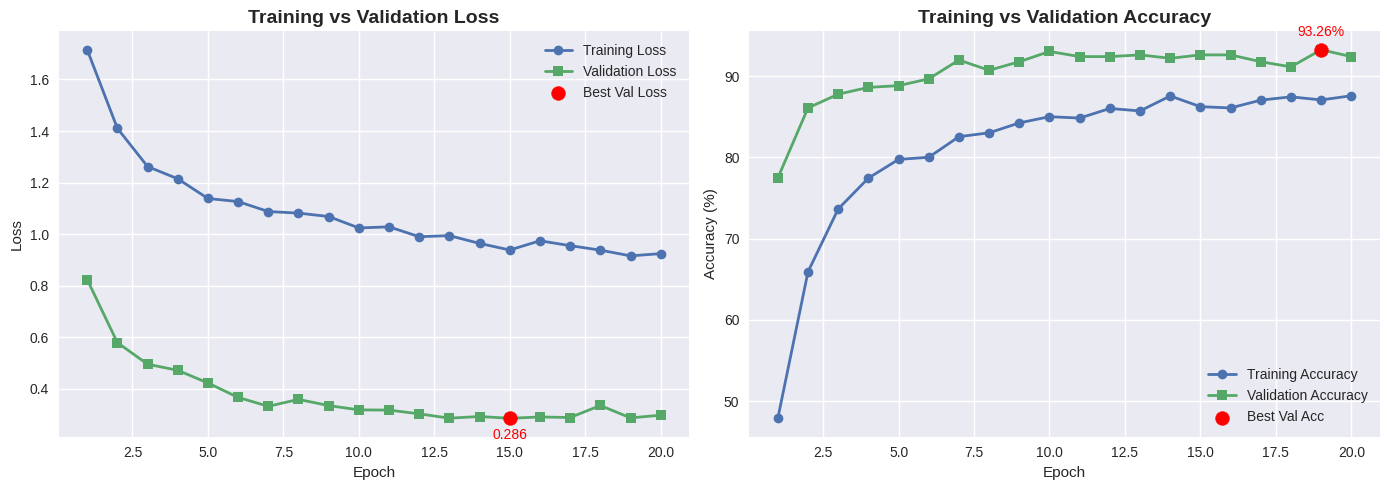

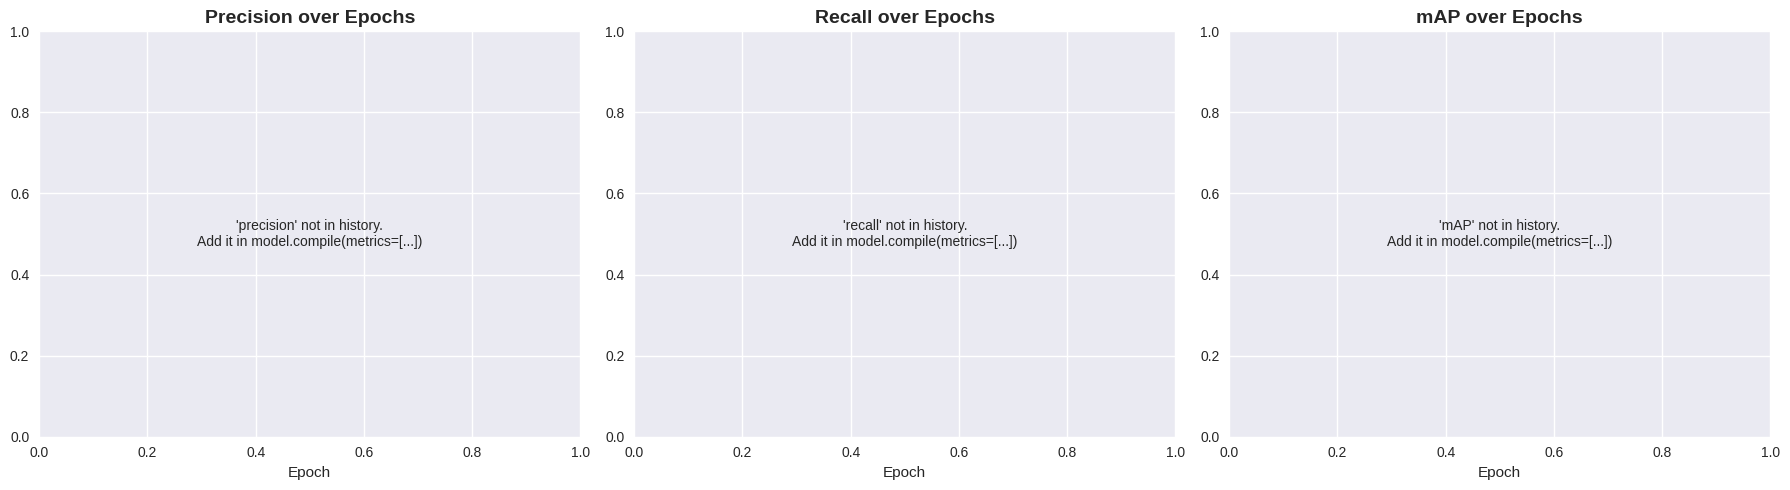

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

h = history.history
epochs = np.arange(1, len(h["loss"]) + 1)


fig, axs = plt.subplots(1, 2, figsize=(14, 5))


axs[0].plot(epochs, h["loss"], label="Training Loss", linewidth=2, marker="o")
axs[0].plot(epochs, h["val_loss"], label="Validation Loss", linewidth=2, marker="s")

best_val_loss_idx = int(np.argmin(h["val_loss"]))
axs[0].scatter(epochs[best_val_loss_idx], h["val_loss"][best_val_loss_idx],
               color="red", s=100, zorder=5, label="Best Val Loss")
axs[0].annotate(f"{h['val_loss'][best_val_loss_idx]:.3f}",
                (epochs[best_val_loss_idx], h["val_loss"][best_val_loss_idx]),
                textcoords="offset points", xytext=(0, -15), ha="center", color="red")

axs[0].set_title("Training vs Validation Loss", fontsize=14, fontweight="bold")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

train_acc = h.get("accuracy") or h.get("acc")
val_acc   = h.get("val_accuracy") or h.get("val_acc")

if train_acc is not None and val_acc is not None:
    train_acc_pct = np.array(train_acc) * 100
    val_acc_pct   = np.array(val_acc) * 100

    axs[1].plot(epochs, train_acc_pct, label="Training Accuracy", linewidth=2, marker="o")
    axs[1].plot(epochs, val_acc_pct, label="Validation Accuracy", linewidth=2, marker="s")

    best_val_acc_idx = int(np.argmax(val_acc_pct))
    axs[1].scatter(epochs[best_val_acc_idx], val_acc_pct[best_val_acc_idx],
                   color="red", s=100, zorder=5, label="Best Val Acc")
    axs[1].annotate(f"{val_acc_pct[best_val_acc_idx]:.2f}%",
                    (epochs[best_val_acc_idx], val_acc_pct[best_val_acc_idx]),
                    textcoords="offset points", xytext=(0, 10), ha="center", color="red")
else:
    axs[1].text(0.5, 0.5, "Accuracy not found in history.\nCheck model.compile(metrics=['accuracy'])",
                ha="center", va="center")

axs[1].set_title("Training vs Validation Accuracy", fontsize=14, fontweight="bold")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()




fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Helper to plot if metric exists
def plot_metric(ax, key, title):
    if key not in h:
        ax.text(0.5, 0.5, f"'{key}' not in history.\nAdd it in model.compile(metrics=[...])",
                ha="center", va="center")
        ax.set_title(title, fontsize=14, fontweight="bold")
        ax.set_xlabel("Epoch")
        ax.grid(True)
        return

    y = np.array(h[key])
    ax.plot(epochs, y, marker="o", linewidth=2)
    best_idx = int(np.argmax(y))
    ax.scatter(epochs[best_idx], y[best_idx], color="red", s=100, zorder=5)
    ax.annotate(f"{y[best_idx]:.2f}",
                (epochs[best_idx], y[best_idx]),
                textcoords="offset points", xytext=(0, 10), ha="center", color="red")
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(key)
    ax.grid(True)

plot_metric(axs[0], "precision", "Precision over Epochs")
plot_metric(axs[1], "recall", "Recall over Epochs")

# mAP key varies; try common names
map_key = "mAP" if "mAP" in h else ("map" if "map" in h else "mAP")
plot_metric(axs[2], map_key, "mAP over Epochs")

plt.tight_layout()
plt.show()


Accuracy : 0.9284210526315789
Precision: 0.9283256328862274
Recall   : 0.9284210526315789
F1-score : 0.9279533336241692


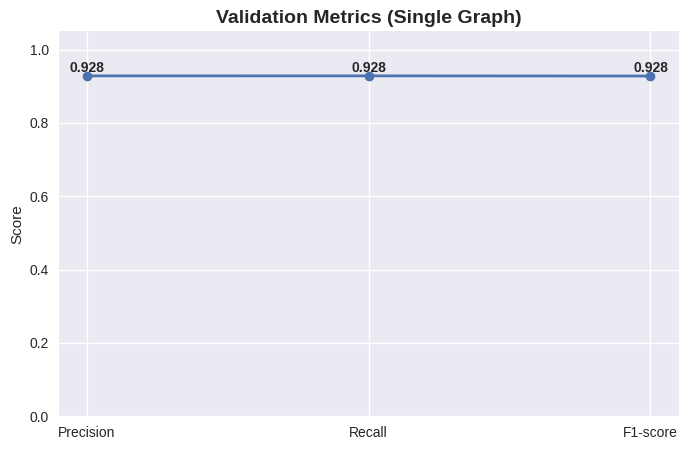

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# ---- Metrics ----
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall    = recall_score(y_true, y_pred, average='weighted')
f1        = f1_score(y_true, y_pred, average='weighted')

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)


plt.figure(figsize=(8, 5))

metrics = ["Precision", "Recall", "F1-score"]
values = [precision, recall, f1]

plt.plot(metrics, values, marker="o", linewidth=2)

# annotate values
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontweight="bold")

plt.ylim(0, 1.05)
plt.title("Validation Metrics (Single Graph)", fontsize=14, fontweight="bold")
plt.ylabel("Score")
plt.grid(True)
plt.show()


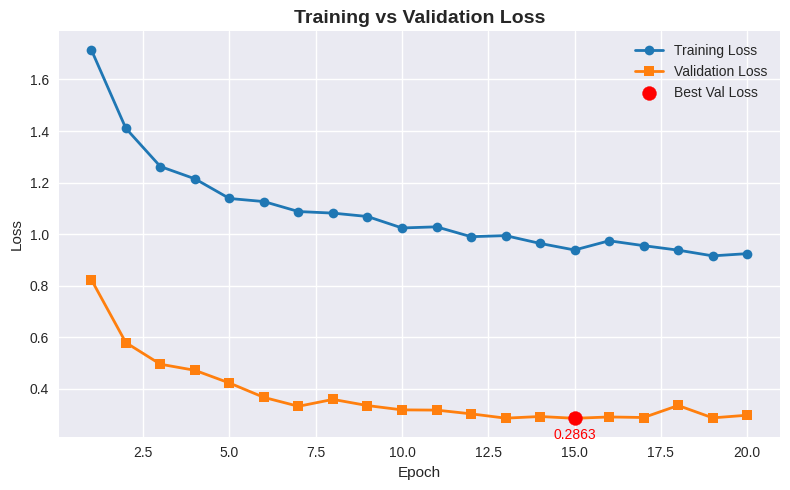

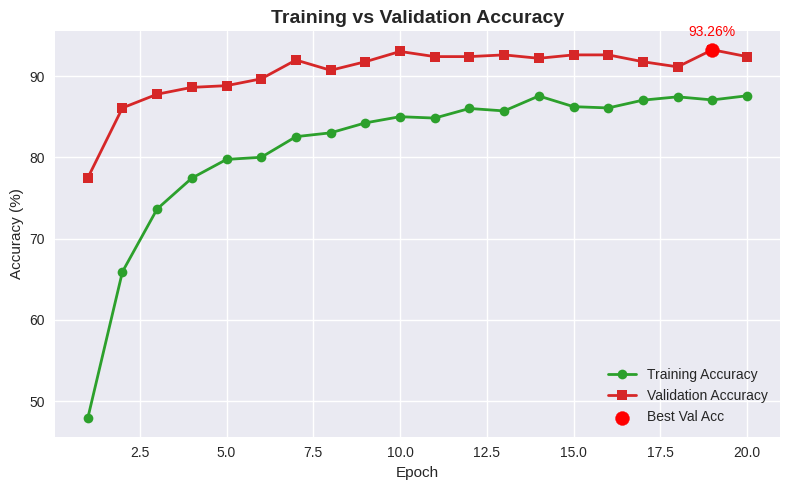

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8")
colors = plt.cm.tab10.colors


def get_hist_key(h, candidates):
    for k in candidates:
        if k in h:
            return k
    return None

H = history.history  

# Extract common keys with fallbacks
loss_k       = get_hist_key(H, ["loss"])
val_loss_k   = get_hist_key(H, ["val_loss"])

acc_k        = get_hist_key(H, ["accuracy", "acc"])
val_acc_k    = get_hist_key(H, ["val_accuracy", "val_acc"])

prec_k       = get_hist_key(H, ["precision", "prec", "Precision", "train_precision"])
val_prec_k   = get_hist_key(H, ["val_precision", "val_prec", "Val_Precision"])

recall_k     = get_hist_key(H, ["recall", "Recall", "train_recall"])
val_recall_k = get_hist_key(H, ["val_recall", "Val_Recall"])

map_k        = get_hist_key(H, ["mAP", "map", "mean_average_precision", "MeanAP"])
val_map_k    = get_hist_key(H, ["val_mAP", "val_map", "val_mean_average_precision", "Val_MeanAP"])

epochs = np.arange(1, len(next(iter(H.values()))) + 1)


if loss_k is not None:
    plt.figure(figsize=(8,5))
    plt.plot(epochs, H[loss_k], label="Training Loss",
             linewidth=2, marker="o", color=colors[0])
    if val_loss_k is not None:
        plt.plot(epochs, H[val_loss_k], label="Validation Loss",
                 linewidth=2, marker="s", color=colors[1])
        best_val_loss_idx = int(np.argmin(H[val_loss_k]))
        plt.scatter(epochs[best_val_loss_idx], H[val_loss_k][best_val_loss_idx],
                    color="red", s=100, zorder=5, label="Best Val Loss")
        plt.annotate(f"{H[val_loss_k][best_val_loss_idx]:.4f}",
                     (epochs[best_val_loss_idx], H[val_loss_k][best_val_loss_idx]),
                     textcoords="offset points", xytext=(0,-15), ha='center', color="red")
    plt.title("Training vs Validation Loss", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def maybe_to_percent(arr):
    arr = np.array(arr, dtype=float)
    if np.nanmax(arr) <= 1.0:
        return arr * 100.0
    return arr

if acc_k is not None:
    train_acc = maybe_to_percent(H[acc_k])
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_acc, label="Training Accuracy",
             linewidth=2, marker="o", color=colors[2])

    if val_acc_k is not None:
        val_acc = maybe_to_percent(H[val_acc_k])
        plt.plot(epochs, val_acc, label="Validation Accuracy",
                 linewidth=2, marker="s", color=colors[3])
        best_val_acc_idx = int(np.argmax(val_acc))
        plt.scatter(epochs[best_val_acc_idx], val_acc[best_val_acc_idx],
                    color="red", s=100, zorder=5, label="Best Val Acc")
        plt.annotate(f"{val_acc[best_val_acc_idx]:.2f}%",
                     (epochs[best_val_acc_idx], val_acc[best_val_acc_idx]),
                     textcoords="offset points", xytext=(0,10), ha='center', color="red")

    plt.title("Training vs Validation Accuracy", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if prec_k is not None:
    prec_vals = np.array(H[prec_k], dtype=float)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, prec_vals, marker="o", linewidth=2, color=colors[4], label="Precision")
    best_prec_idx = int(np.nanargmax(prec_vals))
    plt.scatter(epochs[best_prec_idx], prec_vals[best_prec_idx], color="red", s=100, zorder=5)
    plt.annotate(f"{prec_vals[best_prec_idx]:.4f}",
                 (epochs[best_prec_idx], prec_vals[best_prec_idx]),
                 textcoords="offset points", xytext=(0,10), ha='center', color="red")
    if val_prec_k is not None:
        val_prec_vals = np.array(H[val_prec_k], dtype=float)
        plt.plot(epochs, val_prec_vals, marker="s", linewidth=2, color=colors[1], label="Val Precision")
        best_vp_idx = int(np.nanargmax(val_prec_vals))
        plt.scatter(epochs[best_vp_idx], val_prec_vals[best_vp_idx], color="purple", s=80, zorder=5)
    plt.title("Precision over Epochs", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


if recall_k is not None:
    recall_vals = np.array(H[recall_k], dtype=float)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, recall_vals, marker="o", linewidth=2, color=colors[5], label="Recall")
    best_recall_idx = int(np.nanargmax(recall_vals))
    plt.scatter(epochs[best_recall_idx], recall_vals[best_recall_idx], color="red", s=100, zorder=5)
    plt.annotate(f"{recall_vals[best_recall_idx]:.4f}",
                 (epochs[best_recall_idx], recall_vals[best_recall_idx]),
                 textcoords="offset points", xytext=(0,10), ha='center', color="red")
    if val_recall_k is not None:
        val_recall_vals = np.array(H[val_recall_k], dtype=float)
        plt.plot(epochs, val_recall_vals, marker="s", linewidth=2, color=colors[6], label="Val Recall")
        best_vr_idx = int(np.nanargmax(val_recall_vals))
        plt.scatter(epochs[best_vr_idx], val_recall_vals[best_vr_idx], color="purple", s=80, zorder=5)
    plt.title("Recall over Epochs", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if map_k is not None:
    map_vals = np.array(H[map_k], dtype=float)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, map_vals, marker="o", linewidth=2, color=colors[6], label="mAP")
    best_map_idx = int(np.nanargmax(map_vals))
    plt.scatter(epochs[best_map_idx], map_vals[best_map_idx], color="red", s=100, zorder=5)
    plt.annotate(f"{map_vals[best_map_idx]:.4f}",
                 (epochs[best_map_idx], map_vals[best_map_idx]),
                 textcoords="offset points", xytext=(0,10), ha='center', color="red")
    if val_map_k is not None:
        val_map_vals = np.array(H[val_map_k], dtype=float)
        plt.plot(epochs, val_map_vals, marker="s", linewidth=2, color=colors[1], label="Val mAP")
        best_vmap_idx = int(np.nanargmax(val_map_vals))
        plt.scatter(epochs[best_vmap_idx], val_map_vals[best_vmap_idx], color="purple", s=80, zorder=5)
    plt.title("mAP over Epochs", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


=== Available history keys ===
['accuracy', 'loss', 'val_accuracy', 'val_loss']


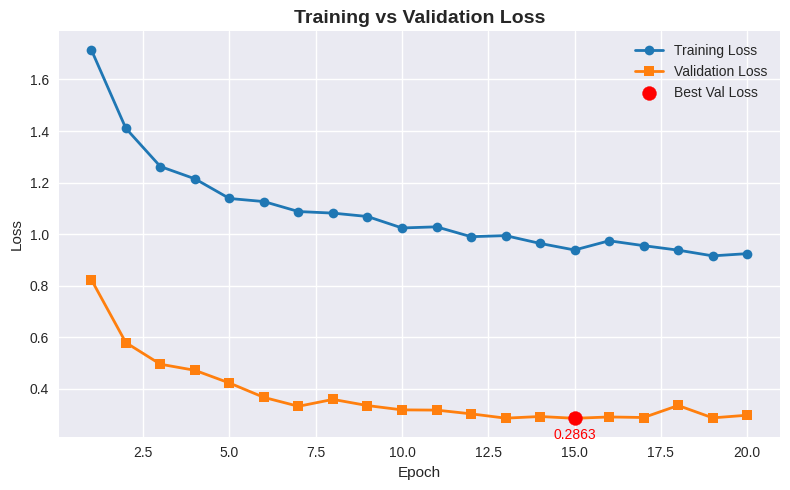

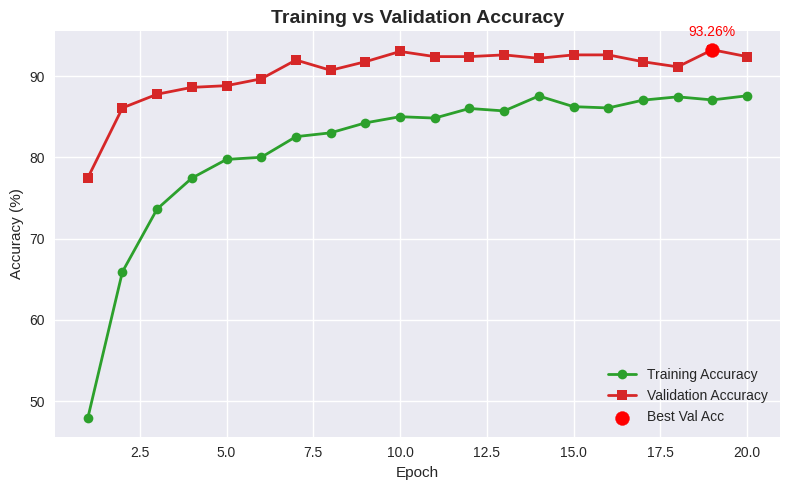

(!) Precision not found in history. Ensure you compiled with tf.keras.metrics.Precision().
(!) Recall not found in history. Ensure you compiled with tf.keras.metrics.Recall().
(!) mAP not found in history. If you need mAP, compute it via a custom callback/metric and return it in history.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
colors = plt.cm.tab10.colors
H = history.history

print("=== Available history keys ===")
print(sorted(H.keys()))

epochs = np.arange(1, len(next(iter(H.values()))) + 1)

def maybe_to_percent(arr):
    arr = np.array(arr, dtype=float)
    return arr * 100.0 if np.nanmax(arr) <= 1.0 else arr

def find_pair(metric_base_names):
    """
    Given list of possible base names (e.g., ['precision','prec','mAP','map']),
    try to find (train_key, val_key) in history. Accepts variants like:
    'precision', 'precision_1', 'map', 'map_50', and their 'val_' counterparts.
    Returns (train_key, val_key or None)
    """
    keys = list(H.keys())
    # find train key
    for base in metric_base_names:
        # exact match first
        cand = [k for k in keys if k == base]
        if cand:
            train_k = cand[0]
            # find matching val key for this base or suffix variant
            suffix = train_k[len(base):]  # e.g., '_1' or '_50'
            val_cands = [f"val_{base}{suffix}", f"val_{train_k}"]
            for vk in val_cands:
                if vk in H:
                    return train_k, vk
            return train_k, None
        # look for suffix variants like precision_1, map_50
        cand = [k for k in keys if k.startswith(base + "_")]
        if cand:
            train_k = sorted(cand)[0]  # pick the first deterministically
            suffix = train_k[len(base):]  # e.g., '_1' or '_50'
            val_cands = [f"val_{base}{suffix}", f"val_{train_k}"]
            for vk in val_cands:
                if vk in H:
                    return train_k, vk
            return train_k, None
    return None, None

loss_k = "loss" if "loss" in H else None
val_loss_k = "val_loss" if "val_loss" in H else None

if loss_k:
    plt.figure(figsize=(8,5))
    plt.plot(epochs, H[loss_k], label="Training Loss", linewidth=2, marker="o", color=colors[0])
    if val_loss_k:
        plt.plot(epochs, H[val_loss_k], label="Validation Loss", linewidth=2, marker="s", color=colors[1])
        best_val_loss_idx = int(np.nanargmin(H[val_loss_k]))
        plt.scatter(epochs[best_val_loss_idx], H[val_loss_k][best_val_loss_idx],
                    color="red", s=100, zorder=5, label="Best Val Loss")
        plt.annotate(f"{H[val_loss_k][best_val_loss_idx]:.4f}",
                     (epochs[best_val_loss_idx], H[val_loss_k][best_val_loss_idx]),
                     textcoords="offset points", xytext=(0,-15), ha='center', color="red")
    plt.title("Training vs Validation Loss", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

acc_k = "accuracy" if "accuracy" in H else ("acc" if "acc" in H else None)
val_acc_k = "val_accuracy" if "val_accuracy" in H else ("val_acc" if "val_acc" in H else None)

if acc_k:
    train_acc = maybe_to_percent(H[acc_k])
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_acc, label="Training Accuracy", linewidth=2, marker="o", color=colors[2])
    if val_acc_k:
        val_acc = maybe_to_percent(H[val_acc_k])
        plt.plot(epochs, val_acc, label="Validation Accuracy", linewidth=2, marker="s", color=colors[3])
        best_val_acc_idx = int(np.nanargmax(val_acc))
        plt.scatter(epochs[best_val_acc_idx], val_acc[best_val_acc_idx],
                    color="red", s=100, zorder=5, label="Best Val Acc")
        plt.annotate(f"{val_acc[best_val_acc_idx]:.2f}%",
                     (epochs[best_val_acc_idx], val_acc[best_val_acc_idx]),
                     textcoords="offset points", xytext=(0,10), ha='center', color="red")
    plt.title("Training vs Validation Accuracy", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



prec_train_k, prec_val_k = find_pair(["precision", "prec", "Precision"])
if prec_train_k:
    prec_vals = np.array(H[prec_train_k], dtype=float)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, prec_vals, marker="o", linewidth=2, color=colors[4], label=f"Precision ({prec_train_k})")
    best_idx = int(np.nanargmax(prec_vals))
    plt.scatter(epochs[best_idx], prec_vals[best_idx], color="red", s=100, zorder=5)
    plt.annotate(f"{prec_vals[best_idx]:.4f}", (epochs[best_idx], prec_vals[best_idx]),
                 textcoords="offset points", xytext=(0,10), ha='center', color="red")
    if prec_val_k:
        val_vals = np.array(H[prec_val_k], dtype=float)
        plt.plot(epochs, val_vals, marker="s", linewidth=2, color=colors[1], label=f"Val Precision ({prec_val_k})")
    plt.title("Precision over Epochs", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch"); plt.ylabel("Precision"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("(!) Precision not found in history. Ensure you compiled with tf.keras.metrics.Precision().")



rec_train_k, rec_val_k = find_pair(["recall", "Recall"])
if rec_train_k:
    rec_vals = np.array(H[rec_train_k], dtype=float)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, rec_vals, marker="o", linewidth=2, color=colors[5], label=f"Recall ({rec_train_k})")
    best_idx = int(np.nanargmax(rec_vals))
    plt.scatter(epochs[best_idx], rec_vals[best_idx], color="red", s=100, zorder=5)
    plt.annotate(f"{rec_vals[best_idx]:.4f}", (epochs[best_idx], rec_vals[best_idx]),
                 textcoords="offset points", xytext=(0,10), ha='center', color="red")
    if rec_val_k:
        val_vals = np.array(H[rec_val_k], dtype=float)
        plt.plot(epochs, val_vals, marker="s", linewidth=2, color=colors[6], label=f"Val Recall ({rec_val_k})")
    plt.title("Recall over Epochs", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch"); plt.ylabel("Recall"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("(!) Recall not found in history. Ensure you compiled with tf.keras.metrics.Recall().")


map_train_k, map_val_k = find_pair(["mAP", "map", "mean_average_precision", "map_50", "map50"])
if map_train_k:
    map_vals = np.array(H[map_train_k], dtype=float)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, map_vals, marker="o", linewidth=2, color=colors[6], label=f"mAP ({map_train_k})")
    best_idx = int(np.nanargmax(map_vals))
    plt.scatter(epochs[best_idx], map_vals[best_idx], color="red", s=100, zorder=5)
    plt.annotate(f"{map_vals[best_idx]:.4f}", (epochs[best_idx], map_vals[best_idx]),
                 textcoords="offset points", xytext=(0,10), ha='center', color="red")
    if map_val_k:
        val_vals = np.array(H[map_val_k], dtype=float)
        plt.plot(epochs, val_vals, marker="s", linewidth=2, color=colors[1], label=f"Val mAP ({map_val_k})")
    plt.title("mAP over Epochs", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch"); plt.ylabel("mAP"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("(!) mAP not found in history. If you need mAP, compute it via a custom callback/metric and return it in history.")


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))


accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall    = recall_score(y_true, y_pred, average='weighted')
f1        = f1_score(y_true, y_pred, average='weighted')

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)


Accuracy : 0.9284210526315789
Precision: 0.9283256328862274
Recall   : 0.9284210526315789
F1-score : 0.9279533336241692


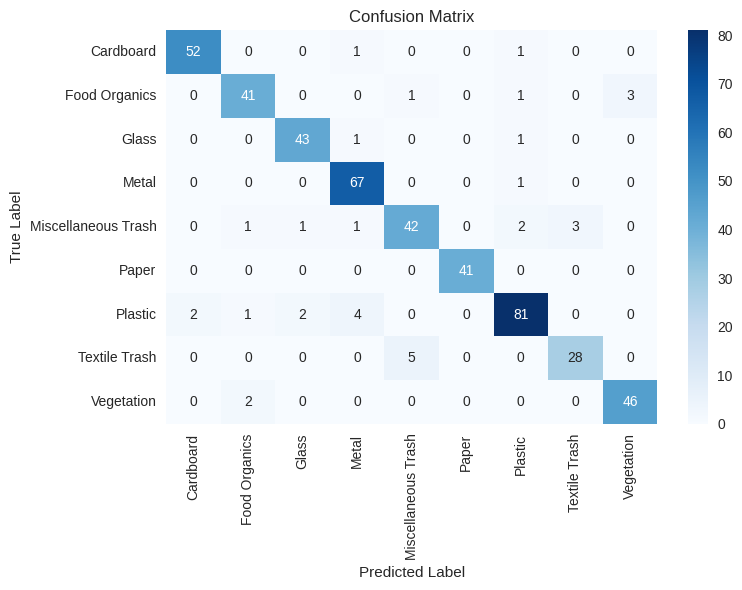

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


CLASS_NAMES = sorted(os.listdir(DATA_DIR + "/train"))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [28]:
import os
from sklearn.metrics import classification_report

CLASS_NAMES = sorted(os.listdir(DATA_DIR + "/train"))

print(classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES
))


                     precision    recall  f1-score   support

          Cardboard       0.96      0.96      0.96        54
      Food Organics       0.91      0.89      0.90        46
              Glass       0.93      0.96      0.95        45
              Metal       0.91      0.99      0.94        68
Miscellaneous Trash       0.88      0.84      0.86        50
              Paper       1.00      1.00      1.00        41
            Plastic       0.93      0.90      0.92        90
      Textile Trash       0.90      0.85      0.88        33
         Vegetation       0.94      0.96      0.95        48

           accuracy                           0.93       475
          macro avg       0.93      0.93      0.93       475
       weighted avg       0.93      0.93      0.93       475



Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.


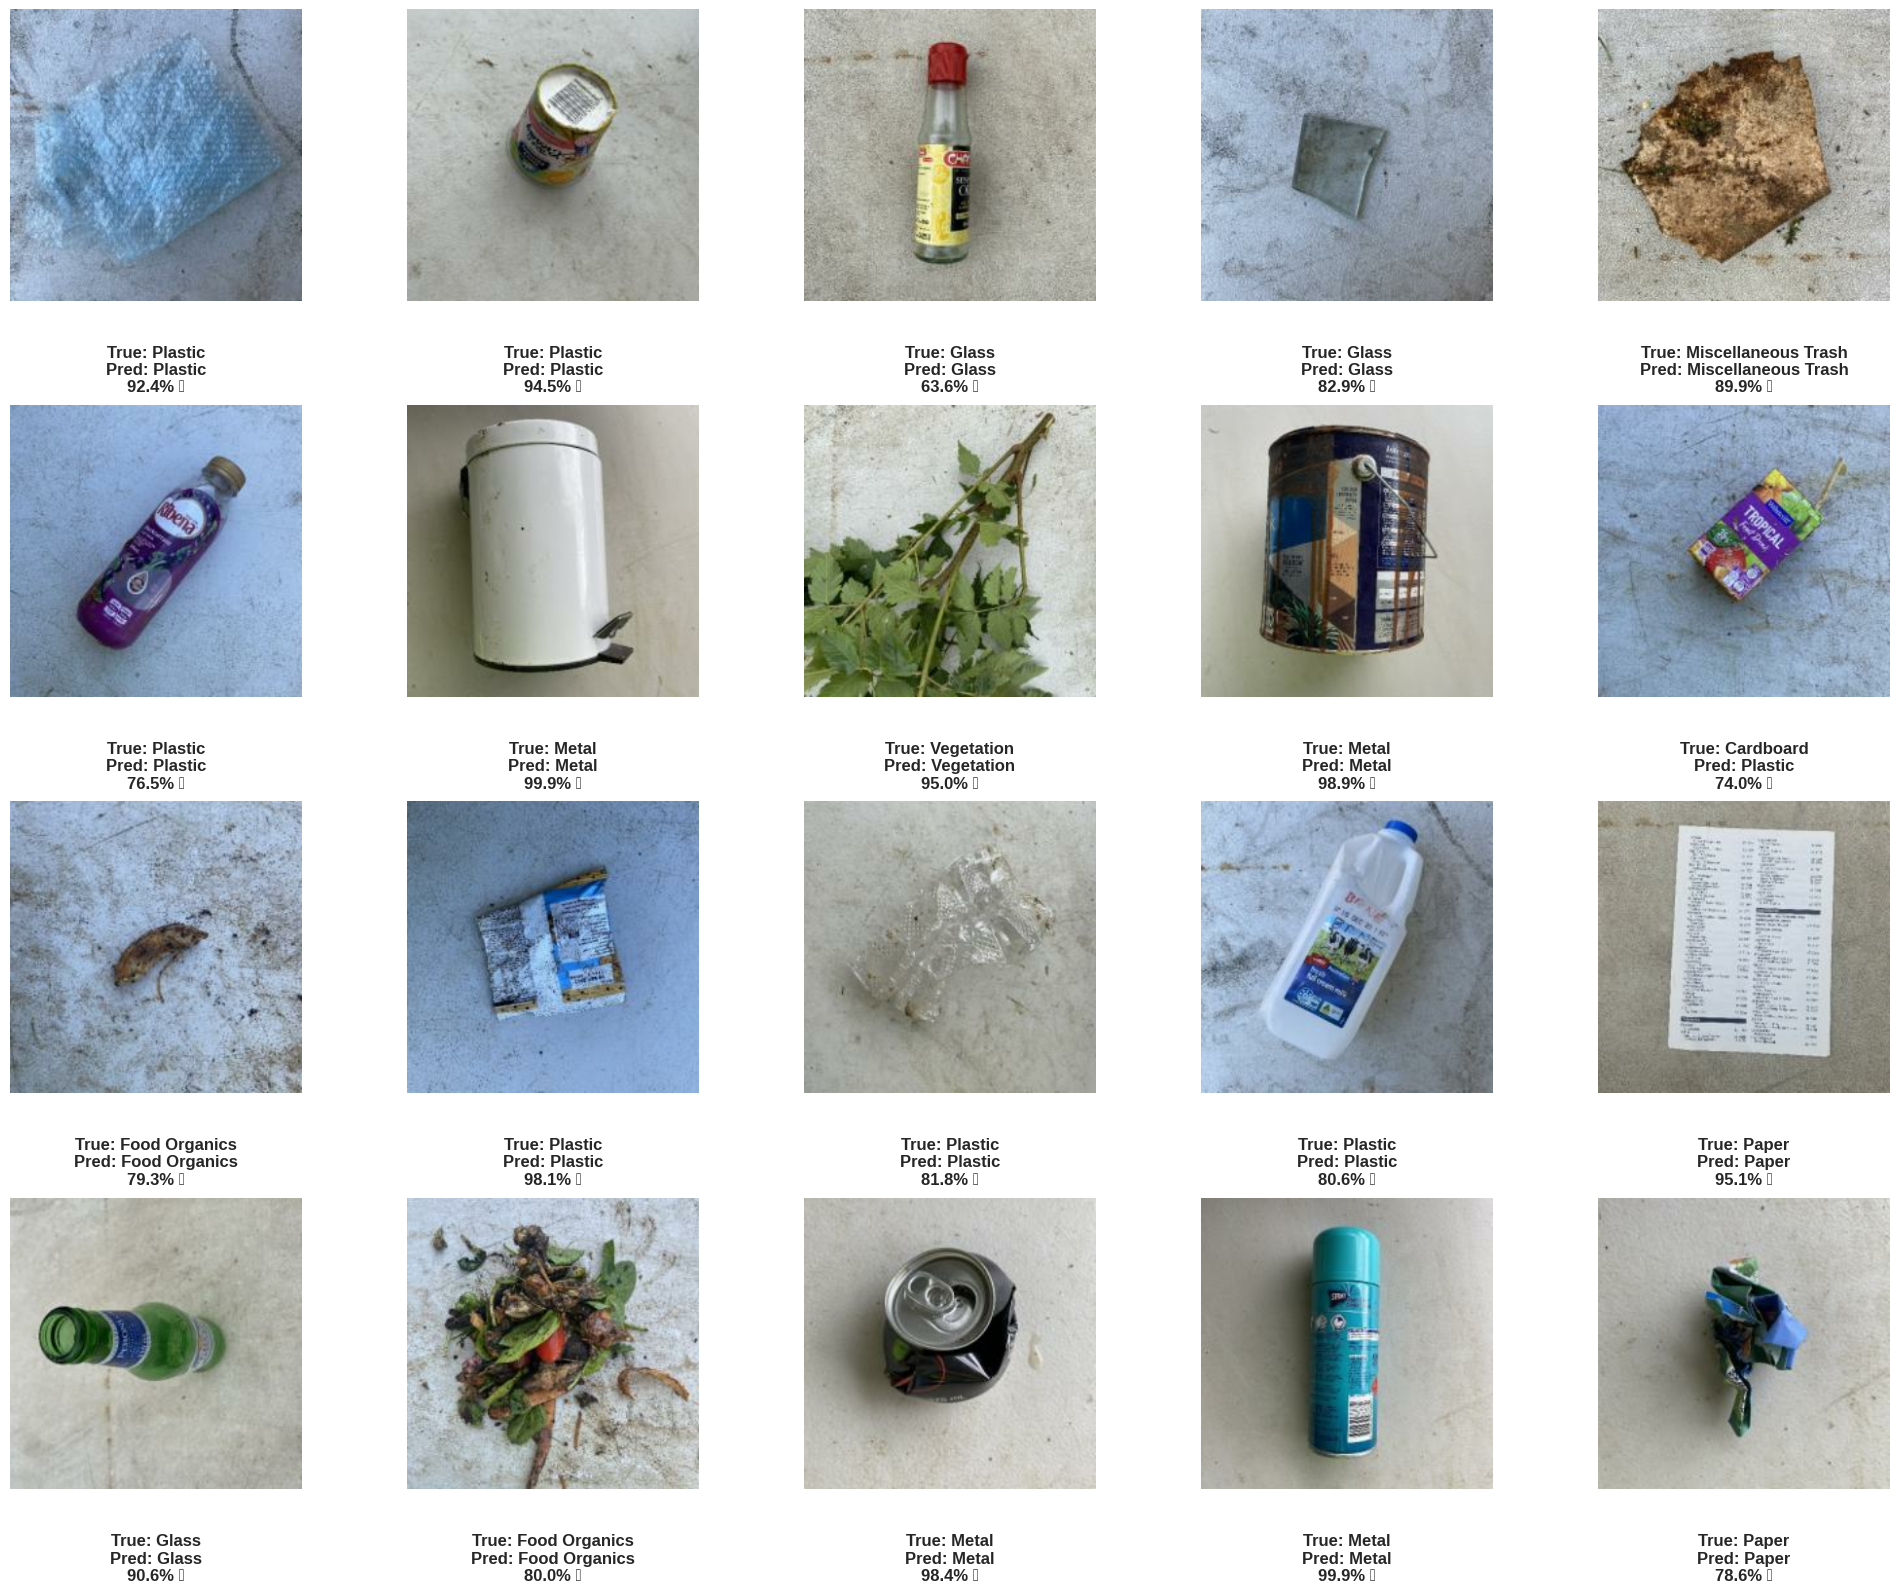

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

CLASS_NAMES = ['Cardboard', 'Food Organics', 'Glass', 'Metal',
               'Miscellaneous Trash', 'Paper', 'Plastic',
               'Textile Trash', 'Vegetation']

def to_display(img):
    x = img.numpy() if hasattr(img, "numpy") else img
    x = x.astype(np.float32)

    if x.max() > 1.5:   # 0..255
        x = x / 255.0
    if x.min() < 0:     # [-1, 1]
        x = (x + 1.0) / 2.0

    return np.clip(x, 0, 1)

def show_val_predictions(val_ds, n=20, cols=5, font_size=12):
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    axes = np.array(axes).reshape(-1)  # flatten
    shown = 0

    for images, labels in val_ds:
        preds = model.predict(images, verbose=0)
        pred_idx = np.argmax(preds, axis=1)
        true_idx = np.argmax(labels.numpy(), axis=1)

        for i in range(images.shape[0]):
            if shown >= n:
                break

            img = to_display(images[i])
            true_name = CLASS_NAMES[int(true_idx[i])]
            pred_name = CLASS_NAMES[int(pred_idx[i])]
            conf = float(np.max(preds[i])) * 100
            correct = (true_name == pred_name)

            ax = axes[shown]
            ax.imshow(img)
            ax.axis("off")

            
            ax.text(
                0.5, -0.15,
                f"True: {true_name}\nPred: {pred_name}\n{conf:.1f}% {'✅' if correct else '❌'}",
                ha="center", va="top",
                transform=ax.transAxes,
                fontsize=font_size,
                fontweight="bold"
            )

            shown += 1

        if shown >= n:
            break


    for j in range(shown, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


show_val_predictions(val_ds, n=20, cols=5, font_size=12)
